# Predicting NBA Salaries with Machine Learning

<img src="https://www.overtimebasket.com/wp-content/uploads/2021/01/IMG_2370-1.jpg" width="500"/>

## Importing packages

In [45]:
from BRScraper import nba

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import shap
import os
import pickle

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesRegressor

from xgboost import XGBRegressor

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.5 MB/s eta 0:00:00


In [2]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 4.2 MB/s eta 0:00:00


In [2]:
!pip install BRScraper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 51.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
cupy-cuda11x 11.0.0 requires numpy<1.26,>=1.20, but you have numpy 1.26.2 which is incompatible.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
models = ['SVM','Random Forest','Elastic Net','AdaBoost','Gradient Boosting','LGBM', 'Linear Regression', 'XGBoost', 'Decision Tree', 'Extra Trees', 'KNN', 'Bagging']

# Path to data
path_data = r'/content/drive/My Drive/DS 340W/NBA Salaries'

sep = r'/'

# Season to predict salaries
desired_seasons = ['2023-24','2022-23','2021-22']

In [6]:
data_cap = {'Year': [2024],
            'Cap Maximum': [142.00]}
cap = pd.DataFrame(data_cap)

cap1 = pd.read_html('https://www.spotrac.com/nba/cba/')[0]
cap1 = cap1[['Year','Cap Maximum']]
cap1['Cap Maximum'] = (cap1['Cap Maximum'].str.replace('$','').str.replace(',','')).astype(float)/1000000

cap = pd.concat([cap, cap1], ignore_index=True)
cap = cap.astype({'Year': 'int32'})

cap.head()

,Year,Cap Maximum
0,2024,142.00
1,2023,136.02
2,2022,123.66
3,2021,112.41
4,2020,109.14


## Opening and processing the data

In [7]:
def get_data_salary(desired_seasons):

    # Players current salaries info
    salary = nba.get_current_salaries()

    salary = salary.drop_duplicates('Player').reset_index(drop=True)

    # Normalizing names
    salary['Player'] = salary['Player'].str.replace('.','')
    salary['Player'] = salary['Player'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

    # Salaries from previous seasons
    for desired_season in desired_seasons:
        url = 'https://hoopshype.com/salaries/players/'+str(int(desired_season[:4])-1)+'-20'+str(int(desired_season[5:7])-1)

        last_season = pd.read_html(url)[0]
        last_season = last_season.drop(['Unnamed: 0',str(int(desired_season[:4])-1)+'/'+str(int(desired_season[5:7])-1)+'(*)'],
                                        axis=1)
        last_season = last_season.rename(columns={str(int(desired_season[:4])-1)+'/'+str(int(desired_season[5:7])-1):
                                                 str(int(desired_season[:4])-1)+'-'+str(int(desired_season[5:7])-1)})

        salary1 = salary[salary['Player'].isin(last_season['Player'])==False]

        last_season['Player'] = last_season['Player'].str.replace('.','')
        last_season['Player'] = last_season['Player'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

        last_season = last_season.drop_duplicates('Player', keep='first').reset_index(drop=True)

        salary = last_season.merge(salary, on='Player', how='left', validate='1:1')

        salary = pd.concat([salary, salary1], ignore_index=True)

        salary = salary.drop_duplicates('Player', keep='first').reset_index(drop=True)

    salary = salary.drop(columns={'Tm'})

    for col in salary.columns:
        if col not in ['Player']:
            salary[col] = (salary[col].str.replace('$','').str.replace(',','')).astype(float)

            salary[col] = salary[col].fillna(-1000000)
            salary[col] = salary[col]/1000000

    return salary

In [8]:
salary = get_data_salary(desired_seasons)

salary.to_csv(path_data+sep+'salaries.csv',sep=',',decimal='.',index=False)

salary.head()

,Player,2020-21,2021-22,2022-23,2023-24,2024-25,2025-26,2026-27,2027-28,2028-29,Guaranteed
0,Stephen Curry,43.01,45.78,48.07,51.92,55.76,59.61,-1.00,-1.00,-1.00,167.28
1,Chris Paul,41.36,30.80,28.40,30.80,30.00,-1.00,-1.00,-1.00,-1.00,15.80
2,Russell Westbrook,41.36,44.21,47.08,3.84,4.03,-1.00,-1.00,-1.00,-1.00,7.86
3,James Harden,41.25,44.31,33.00,35.64,-1.00,-1.00,-1.00,-1.00,-1.00,35.64
4,John Wall,41.25,44.31,47.35,6.80,-1.00,-1.00,-1.00,-1.00,-1.00,6.80


In [9]:
def get_individual_stats(desired_seasons):

    df_stats = pd.DataFrame()

    for desired_season in desired_seasons:
        # Stats for S-1
        per_game = nba.get_stats(int(desired_season[:4]), info='per_game', rename=True)
        totals = nba.get_stats(int(desired_season[:4]), info='totals', rename=True)
        avancados = nba.get_stats(int(desired_season[:4]), info='advanced', rename=True)

        # Droping repeated variables
        totals = totals.drop(['Pos','Age','G','GS','Season'], axis=1).reset_index(drop=True)
        avancados = avancados.drop(['Pos','Age','G','MP_advanced','Season'], axis=1).reset_index(drop=True)

        cols = ['Player','Season','Pos','Age','Tm','G','GS']

        # Defining variables type
        for coluna in per_game.columns:
            if coluna not in cols:
                per_game[coluna] = per_game[coluna].astype(float)
        for coluna in totals.columns:
            if coluna not in cols:
                totals[coluna] = totals[coluna].astype(float)
        for coluna in avancados.columns:
            if coluna not in cols:
                avancados[coluna] = avancados[coluna].astype(float)

        times = per_game.drop_duplicates(subset=['Player'],keep='last').reset_index(drop=True)
        times = times['Tm']

        per_game = per_game.drop_duplicates(subset=['Player'],keep='first').reset_index(drop=True)
        totals = totals.drop_duplicates(subset=['Player'],keep='first').reset_index(drop=True)
        avancados = avancados.drop_duplicates(subset=['Player'],keep='first').reset_index(drop=True)

        per_game['Tm'] = times
        totals['Tm'] = times
        avancados['Tm'] = times

        # Merging the bases
        stats = per_game.merge(avancados, on=['Player','Tm'], how='left', validate='1:1')
        stats = stats.merge(totals, on=['Player','Tm'], how='left', validate='1:1').fillna(0)

        stats = stats.astype({'G':int,'GS':int,'Age':int})

        # Normalizing names
        stats['Player'] = stats['Player'].str.replace('.','')
        stats['Player'] = stats['Player'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
        # Trying to match Jrs
        stats['Player'] = stats['Player'].apply(lambda x: x.replace(' Jr', '') if x.endswith(' Jr') and x not in ['Jaren Jackson Jr', 'Tim Hardaway Jr', 'Gary Trent Jr', 'Larry Nance Jr',
                                                                                                                 'Duane Washington Jr', 'Scottie Pippen Jr', 'Vince Williams Jr', 'Ron Harper Jr'] else x)
        df_stats = pd.concat([df_stats, stats], ignore_index=True)

    df_stats = df_stats.rename(columns={'Season':'Season S-1'})

    return df_stats

In [10]:
stats = get_individual_stats(desired_seasons)

stats.to_csv(path_data+sep+'stats.csv',sep=',',decimal='.',index=False)

stats

,Player,Pos,Age,Tm,G,GS,MP_per_game,FG_per_game,FGA_per_game,FG%_per_game,3P_per_game,3PA_per_game,3P%_per_game,2P_per_game,2PA_per_game,2P%_per_game,eFG%_per_game,FT_per_game,FTA_per_game,FT%_per_game,ORB_per_game,DRB_per_game,TRB_per_game,AST_per_game,STL_per_game,BLK_per_game,TOV_per_game,PF_per_game,PTS_per_game,Season S-1,PER_advanced,TS%_advanced,3PAr_advanced,FTr_advanced,ORB%_advanced,DRB%_advanced,TRB%_advanced,AST%_advanced,STL%_advanced,BLK%_advanced,TOV%_advanced,USG%_advanced,OWS_advanced,DWS_advanced,WS_advanced,WS/48_advanced,OBPM_advanced,DBPM_advanced,BPM_advanced,VORP_advanced,MP_totals,FG_totals,FGA_totals,FG%_totals,3P_totals,3PA_totals,3P%_totals,2P_totals,2PA_totals,2P%_totals,eFG%_totals,FT_totals,FTA_totals,FT%_totals,ORB_totals,DRB_totals,TRB_totals,AST_totals,STL_totals,BLK_totals,TOV_totals,PF_totals,PTS_totals
0,Precious Achiuwa,C,23,TOR,55,12,20.70,3.60,7.30,0.48,0.50,2.00,0.27,3.00,5.40,0.56,0.52,1.60,2.30,0.70,1.80,4.10,6.00,0.90,0.60,0.50,1.10,1.90,9.20,2022-23,15.20,0.55,0.27,0.31,9.30,24.40,16.30,6.30,1.30,2.60,11.40,19.40,0.80,1.40,2.20,0.09,-1.40,-0.80,-2.30,-0.10,1140.00,196.00,404.00,0.48,29.00,108.00,0.27,167.00,296.00,0.56,0.52,87.00,124.00,0.70,100.00,228.00,328.00,50.00,31.00,30.00,59.00,102.00,508.00
1,Steven Adams,C,29,MEM,42,42,27.00,3.70,6.30,0.60,0.00,0.00,0.00,3.70,6.20,0.60,0.60,1.10,3.10,0.36,5.10,6.50,11.50,2.30,0.90,1.10,1.90,2.30,8.60,2022-23,17.50,0.56,0.00,0.49,20.10,25.30,22.70,11.20,1.50,3.70,19.80,14.60,1.30,2.10,3.40,0.14,-0.30,0.90,0.60,0.70,1133.00,157.00,263.00,0.60,0.00,1.00,0.00,157.00,262.00,0.60,0.60,47.00,129.00,0.36,214.00,271.00,485.00,97.00,36.00,46.00,79.00,98.00,361.00
2,Bam Adebayo,C,25,MIA,75,75,34.60,8.00,14.90,0.54,0.00,0.20,0.08,8.00,14.70,0.55,0.54,4.30,5.40,0.81,2.50,6.70,9.20,3.20,1.20,0.80,2.50,2.80,20.40,2022-23,20.10,0.59,0.01,0.36,8.00,23.60,15.50,15.90,1.70,2.40,12.70,25.20,3.60,3.80,7.40,0.14,0.80,0.80,1.50,2.30,2598.00,602.00,1114.00,0.54,1.00,12.00,0.08,601.00,1102.00,0.55,0.54,324.00,402.00,0.81,184.00,504.00,688.00,240.00,88.00,61.00,187.00,208.00,1529.00
3,Ochai Agbaji,SG,22,UTA,59,22,20.50,2.80,6.50,0.43,1.40,3.90,0.35,1.40,2.70,0.53,0.53,0.90,1.20,0.81,0.70,1.30,2.10,1.10,0.30,0.30,0.70,1.70,7.90,2022-23,9.50,0.56,0.59,0.18,3.90,6.90,5.40,7.50,0.60,1.00,9.00,15.80,0.90,0.40,1.30,0.05,-1.70,-1.40,-3.00,-0.30,1209.00,165.00,386.00,0.43,81.00,228.00,0.35,84.00,158.00,0.53,0.53,56.00,69.00,0.81,43.00,78.00,121.00,67.00,16.00,15.00,41.00,99.00,467.00
4,Santi Aldama,PF,22,MEM,77,20,21.80,3.20,6.80,0.47,1.20,3.50,0.35,2.00,3.40,0.59,0.56,1.40,1.90,0.75,1.10,3.70,4.80,1.30,0.60,0.60,0.80,1.90,9.00,2022-23,13.90,0.59,0.51,0.27,5.40,18.00,11.70,7.60,1.30,2.60,9.30,16.00,2.10,2.40,4.60,0.13,-0.30,0.80,0.50,1.10,1682.00,247.00,525.00,0.47,94.00,266.00,0.35,153.00,259.00,0.59,0.56,108.00,144.00,0.75,85.00,286.00,371.00,97.00,45.00,48.00,60.00,143.00,696.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,Delon Wright,PG,28,SAC,63,39,27.70,3.80,8.20,0.46,1.00,2.70,0.37,2.80,5.50,0.51,0.53,1.60,2.00,0.80,1.00,3.20,4.30,4.40,1.60,0.50,1.30,1.20,10.20,2020-21,16.30,0.56,0.33,0.24,4.10,13.10,8.60,23.00,2.80,1.50,12.60,16.30,2.50,1.80,4.30,0.12,0.60,1.50,2.20,1.80,1748.00,240.00,518.00,0.46,64.00,172.00,0.37,176.00,346.00,0.51,0.53,101.00,126.00,0.80,65.00,204.00,269.00,278.00,101.00,30.00,83.00,75.00,645.00
1680,Thaddeus Young,PF,32,CHI,68,23,24.30,5.40,9.70,0.56,0.20,0.70,0.27,5.30,9.10,0.58,0.57,1.00,1.70,0.63,2.50,3.80,6.20,4.30,1.10,0.60,2.00,2.20,12.10,2020-21,20.30,0.58,0.07,0.17,11.40,16.90,14.20,27.10,2.20,2.10,16.10,22.30,2.80,2.20,5.10,0.15,1.90,1.40,3.30,2.20,1652.00,370.00,662.00,0.56,12.00,45.00,0.27,358.00,617.00,0.58,0.57,71.00,113.00,0.63,168.00,255.00,423.00,291.00,74.00,40.00,137.00,152.0

In [11]:
def select_data(desired_seasons, stats, salary, cap):

    df_f = pd.DataFrame()

    for desired_season in desired_seasons:
        # Selecting only salaries of S and S-1
        salary1 = salary[['Player', desired_season,
                         str(int(desired_season[:4])-1)+'-'+str(int(desired_season[5:7])-1)]]

        stats1 = stats[stats['Season S-1']==str(int(desired_season[:4])-1)+'-'+str(int(desired_season[5:7])-1)]

        df = stats1.merge(salary1, on='Player', how='left', validate='1:1')

        df = df.rename(columns={str(int(desired_season[:4])-1)+'-'+str(int(desired_season[5:7])-1):'Salary S-1',
                                  desired_season:'Salary S'})

        # Removing null values
        df = df[(df['Salary S']!=-1) & (df['Salary S'].notna())]

        df['Year S'] = ('20'+((df['Season S-1'].str[5:7]).astype(int)+1).astype(str)).astype(int)
        df['Year S-1'] = ('20'+(df['Season S-1'].str[5:7]).astype(str)).astype(int)

        cap2 = cap.rename(columns={'Cap Maximum':'Cap Maximum S', 'Year':'Year S'})
        df = df.merge(cap2, how='left', on='Year S', validate='m:1')

        cap2 = cap2.rename(columns={'Cap Maximum S':'Cap Maximum S-1', 'Year S':'Year S-1'})
        df = df.merge(cap2, how='left', on='Year S-1', validate='m:1')

        df['% of Cap S-1'] = df['Salary S-1']/df['Cap Maximum S-1']*100
        df['% of Cap S-1'][df['% of Cap S-1']<0] = -1

        df['% of Cap S'] = df['Salary S']/df['Cap Maximum S']*100
        df['% of Cap S'][df['% of Cap S']<0] = -1

        # Get dummies for positions
        pos = pd.get_dummies(df['Pos']).astype(int)
        for col in pos.columns:
            if len(col)>3:
                pos = pos.rename(columns={col: col.split('-')[0]})
        pos = pos[['PG','SG','SF','PF','C']]
        pos = pos.groupby(pos.columns, axis=1).sum()

        df = df.join(pos)
        df = df.drop(columns={'Pos','Year S','Year S-1'}).reset_index(drop=True)

        df_f = pd.concat([df_f, df], ignore_index=True)

    df_f = df_f.fillna(0)

    return df_f

In [12]:
df = select_data(desired_seasons, stats, salary, cap)

df.to_csv(path_data+sep+'final_data.csv',sep=',',decimal='.',index=False)

df

,Player,Age,Tm,G,GS,MP_per_game,FG_per_game,FGA_per_game,FG%_per_game,3P_per_game,3PA_per_game,3P%_per_game,2P_per_game,2PA_per_game,2P%_per_game,eFG%_per_game,FT_per_game,FTA_per_game,FT%_per_game,ORB_per_game,DRB_per_game,TRB_per_game,AST_per_game,STL_per_game,BLK_per_game,TOV_per_game,PF_per_game,PTS_per_game,Season S-1,PER_advanced,TS%_advanced,3PAr_advanced,FTr_advanced,ORB%_advanced,DRB%_advanced,TRB%_advanced,AST%_advanced,STL%_advanced,BLK%_advanced,TOV%_advanced,USG%_advanced,OWS_advanced,DWS_advanced,WS_advanced,WS/48_advanced,OBPM_advanced,DBPM_advanced,BPM_advanced,VORP_advanced,MP_totals,FG_totals,FGA_totals,FG%_totals,3P_totals,3PA_totals,3P%_totals,2P_totals,2PA_totals,2P%_totals,eFG%_totals,FT_totals,FTA_totals,FT%_totals,ORB_totals,DRB_totals,TRB_totals,AST_totals,STL_totals,BLK_totals,TOV_totals,PF_totals,PTS_totals,Salary S,Salary S-1,Cap Maximum S,Cap Maximum S-1,% of Cap S-1,% of Cap S,C,PF,PG,SF,SG
0,Precious Achiuwa,23,TOR,55,12,20.70,3.60,7.30,0.48,0.50,2.00,0.27,3.00,5.40,0.56,0.52,1.60,2.30,0.70,1.80,4.10,6.00,0.90,0.60,0.50,1.10,1.90,9.20,2022-23,15.20,0.55,0.27,0.31,9.30,24.40,16.30,6.30,1.30,2.60,11.40,19.40,0.80,1.40,2.20,0.09,-1.40,-0.80,-2.30,-0.10,1140.00,196.00,404.00,0.48,29.00,108.00,0.27,167.00,296.00,0.56,0.52,87.00,124.00,0.70,100.00,228.00,328.00,50.00,31.00,30.00,59.00,102.00,508.00,4.38,2.84,142.00,136.02,2.09,3.08,1,0,0,0,0
1,Steven Adams,29,MEM,42,42,27.00,3.70,6.30,0.60,0.00,0.00,0.00,3.70,6.20,0.60,0.60,1.10,3.10,0.36,5.10,6.50,11.50,2.30,0.90,1.10,1.90,2.30,8.60,2022-23,17.50,0.56,0.00,0.49,20.10,25.30,22.70,11.20,1.50,3.70,19.80,14.60,1.30,2.10,3.40,0.14,-0.30,0.90,0.60,0.70,1133.00,157.00,263.00,0.60,0.00,1.00,0.00,157.00,262.00,0.60,0.60,47.00,129.00,0.36,214.00,271.00,485.00,97.00,36.00,46.00,79.00,98.00,361.00,12.60,17.93,142.00,136.02,13.18,8.87,1,0,0,0,0
2,Bam Adebayo,25,MIA,75,75,34.60,8.00,14.90,0.54,0.00,0.20,0.08,8.00,14.70,0.55,0.54,4.30,5.40,0.81,2.50,6.70,9.20,3.20,1.20,0.80,2.50,2.80,20.40,2022-23,20.10,0.59,0.01,0.36,8.00,23.60,15.50,15.90,1.70,2.40,12.70,25.20,3.60,3.80,7.40,0.14,0.80,0.80,1.50,2.30,2598.00,602.00,1114.00,0.54,1.00,12.00,0.08,601.00,1102.00,0.55,0.54,324.00,402.00,0.81,184.00,504.00,688.00,240.00,88.00,61.00,187.00,208.00,1529.00,32.60,30.35,142.00,136.02,22.31,22.96,1,0,0,0,0
3,Ochai Agbaji,22,UTA,59,22,20.50,2.80,6.50,0.43,1.40,3.90,0.35,1.40,2.70,0.53,0.53,0.90,1.20,0.81,0.70,1.30,2.10,1.10,0.30,0.30,0.70,1.70,7.90,2022-23,9.50,0.56,0.59,0.18,3.90,6.90,5.40,7.50,0.60,1.00,9.00,15.80,0.90,0.40,1.30,0.05,-1.70,-1.40,-3.00,-0.30,1209.00,165.00,386.00,0.43,81.00,228.00,0.35,84.00,158.00,0.53,0.53,56.00,69.00,0.81,43.00,78.00,121.00,67.00,16.00,15.00,41.00,99.00,467.00,4.11,3.92,142.00,136.02,2.88,2.90,0,0,0,0,1
4,Santi Aldama,22,MEM,77,20,21.80,3.20,6.80,0.47,1.20,3.50,0.35,2.00,3.40,0.59,0.56,1.40,1.90,0.75,1.10,3.70,4.80,1.30,0.60,0.60,0.80,1.90,9.00,2022-23,13.90,0.59,0.51,0.27,5.40,18.00,11.70,7.60,1.30,2.60,9.30,16.00,2.10,2.40,4.60,0.13,-0.30,0.80,0.50,1.10,1682.00,247.00,525.00,0.47,94.00,266.00,0.35,153.00,259.00,0.59,0.56,108.00,144.00,0.75,85.00,286.00,371.00,97.00,45.00,48.00,60.00,143.00,696.00,2.19,-1.00,142.00,136.02,-1.00,1.55,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1274,Delon Wright,28,SAC,63,39,27.70,3.80,8.20,0.46,1.00,2.70,0.37,2.80,5.50,0.51,0.53,1.60,2.00,0.80,1.00,3.20,4.30,4.40,1.60,0.50,1.30,1.20,10.20,2020-21,16.30,0.56,0.33,0.24,4.10,13.10,8.60,23.00,2.80,1.50,12.60,16.30,2.50,1.80,4.30,0.12,0.60,1.50,2.20,1.80,1748.00,240.00,518.00,0.46,64.00,172.00,0.37,176.00,346.00,0.51,0.53,101.00,126.00,0.80,65.00,204.00,269.00,278.00,101.00,30.00,83.00,75.00,645.00,8.53,9.00,123.66,112.41,8.01,6.90,0,0,1,0,0
1275,Thaddeus Young,32,C

In [13]:
def get_FAs(desired_seasons):

    # Get free agents
    FAs = pd.DataFrame()

    for desired_season in desired_seasons:
        FAs1 = pd.read_html('https://web.archive.org/web/20230816170811/https://www.spotrac.com/nba/free-agents/'+desired_season[:4])[0]
        FAs1 = FAs1.iloc[:,0]
        FAs2 = pd.read_html('https://web.archive.org/web/20230816170811/https://www.spotrac.com/nba/free-agents/')[1]
        FAs2 = FAs2.iloc[:,0]

        FA = pd.concat([FAs1,FAs2],ignore_index=True)
        FA = FA.to_frame(name="Player")

        FA['Season S-1'] = str(int(desired_season[:4])-1)+'-'+str(int(desired_season[5:7])-1)

        FAs = pd.concat([FA, FAs], ignore_index=True)

    FAs['Player'] = FAs['Player'].str.replace('.','')
    FAs['Player'] = FAs['Player'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

    return FAs

In [14]:
FAs = get_FAs(desired_seasons)
FAs

,Player,Season S-1
0,Sep,2020-21
1,NaN,2020-21
2,2021,2020-21
3,Jerami Grant,2020-21
4,Fred VanVleet,2020-21
...,...,...
364,Jared Butler,2022-23
365,Trevor Keels,2022-23
366,Udoka Azubuike,2022-23
367,Jamal Cain,2022-23


In [15]:
res = df.merge(FAs, on=['Player', 'Season S-1'], how='inner')
res

,Player,Age,Tm,G,GS,MP_per_game,FG_per_game,FGA_per_game,FG%_per_game,3P_per_game,3PA_per_game,3P%_per_game,2P_per_game,2PA_per_game,2P%_per_game,eFG%_per_game,FT_per_game,FTA_per_game,FT%_per_game,ORB_per_game,DRB_per_game,TRB_per_game,AST_per_game,STL_per_game,BLK_per_game,TOV_per_game,PF_per_game,PTS_per_game,Season S-1,PER_advanced,TS%_advanced,3PAr_advanced,FTr_advanced,ORB%_advanced,DRB%_advanced,TRB%_advanced,AST%_advanced,STL%_advanced,BLK%_advanced,TOV%_advanced,USG%_advanced,OWS_advanced,DWS_advanced,WS_advanced,WS/48_advanced,OBPM_advanced,DBPM_advanced,BPM_advanced,VORP_advanced,MP_totals,FG_totals,FGA_totals,FG%_totals,3P_totals,3PA_totals,3P%_totals,2P_totals,2PA_totals,2P%_totals,eFG%_totals,FT_totals,FTA_totals,FT%_totals,ORB_totals,DRB_totals,TRB_totals,AST_totals,STL_totals,BLK_totals,TOV_totals,PF_totals,PTS_totals,Salary S,Salary S-1,Cap Maximum S,Cap Maximum S-1,% of Cap S-1,% of Cap S,C,PF,PG,SF,SG
0,Nickeil Alexander-Walker,24,MIN,59,3,15.00,2.20,5.00,0.44,1.00,2.70,0.38,1.20,2.30,0.52,0.55,0.70,1.00,0.67,0.30,1.50,1.70,1.80,0.50,0.40,0.90,1.50,6.20,2022-23,11.60,0.56,0.54,0.20,1.90,10.50,6.30,16.70,1.70,2.00,14.60,17.90,0.30,0.80,1.10,0.06,-1.40,0.40,-0.90,0.20,884.00,131.00,295.00,0.44,61.00,159.00,0.38,70.00,136.00,0.52,0.55,40.00,60.00,0.67,15.00,86.00,101.00,108.00,32.00,21.00,55.00,88.00,363.00,4.69,5.01,142.00,136.02,3.68,3.30,0,0,0,0,1
1,Thanasis Antetokounmpo,30,MIL,37,0,5.60,0.50,1.20,0.43,0.00,0.20,0.00,0.50,1.00,0.53,0.43,0.30,0.60,0.50,0.40,0.80,1.20,0.40,0.10,0.10,0.30,0.60,1.40,2022-23,6.70,0.46,0.17,0.48,7.90,14.10,11.10,9.30,0.70,1.20,17.70,13.80,-0.10,0.20,0.10,0.02,-6.50,-1.10,-7.60,-0.30,206.00,20.00,46.00,0.43,0.00,8.00,0.00,20.00,38.00,0.53,0.43,11.00,22.00,0.50,15.00,29.00,44.00,15.00,3.00,3.00,12.00,22.00,51.00,2.02,1.88,142.00,136.02,1.38,1.42,0,1,0,0,0
2,Dalano Banton,23,TOR,31,2,9.00,1.80,4.20,0.42,0.50,1.60,0.29,1.30,2.50,0.51,0.48,0.50,0.80,0.71,0.40,1.10,1.50,1.20,0.40,0.40,0.60,1.10,4.60,2022-23,14.90,0.51,0.39,0.18,4.20,14.90,9.10,19.30,2.30,4.50,11.40,24.20,0.00,0.40,0.40,0.06,-1.10,0.60,-0.50,0.10,279.00,55.00,130.00,0.42,15.00,51.00,0.29,40.00,79.00,0.51,0.48,17.00,24.00,0.71,11.00,34.00,45.00,36.00,13.00,13.00,18.00,34.00,142.00,2.02,1.56,142.00,136.02,1.15,1.42,0,0,1,0,0
3,Keita Bates-Diop,27,SAS,67,42,21.70,3.50,6.90,0.51,0.80,2.10,0.39,2.70,4.80,0.56,0.57,1.80,2.20,0.79,1.00,2.70,3.70,1.50,0.70,0.30,0.80,0.90,9.70,2022-23,14.90,0.61,0.30,0.32,4.70,14.30,9.30,9.80,1.50,1.10,9.50,16.70,2.10,0.60,2.70,0.09,0.30,-0.90,-0.60,0.50,1452.00,236.00,465.00,0.51,56.00,142.00,0.39,180.00,323.00,0.56,0.57,119.00,150.00,0.79,65.00,183.00,248.00,103.00,46.00,20.00,56.00,63.00,647.00,2.35,1.88,142.00,136.02,1.38,1.65,0,1,0,0,0
4,Malik Beasley,26,LAL,81,27,25.80,4.60,11.60,0.40,2.90,8.10,0.36,1.70,3.40,0.48,0.52,0.60,0.80,0.77,0.40,3.10,3.50,1.50,0.80,0.10,1.10,1.30,12.70,2022-23,10.90,0.53,0.70,0.07,1.80,12.50,7.30,8.40,1.50,0.40,8.50,21.10,-0.20,1.60,1.40,0.03,-0.90,-1.00,-2.00,0.00,2093.00,370.00,937.00,0.40,235.00,658.00,0.36,135.00,279.00,0.48,0.52,50.00,65.00,0.77,35.00,248.00,283.00,124.00,65.00,9.00,90.00,107.00,1025.00,2.02,15.56,142.00,136.02,11.44,1.42,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,Russell Westbrook,32,WAS,65,65,36.40,8.40,19.00,0.44,1.30,4.20,0.32,7.00,14.80,0.47,0.47,4.20,6.40,0.66,1.70,9.90,11.50,11.70,1.40,0.40,4.80,2.90,22.20,2020-21,19.50,0.51,0.22,0.33,4.90,28.60,16.80,48.60,1.70,0.80,18.00,30.20,0.50,3.20,3.70,0.07,2.60,1.10,3.70,3.40,2369.00,544.00,1238.00,0.44,86.00,273.00,0.32,458.00,965.00,0.47,0.47,271.00,413.00,0.66,109.00,641.00,750.00,763.00,89.00,23.00,312.00,190.00,1445.00,44.21,41.36,123.66,112.41,36.79,35.75,0,0,1,0,0
242,Coby White,20,CH

In [16]:
res.value_counts('Season S-1')

Season S-1
2021-22    87
2022-23    84
2020-21    75
dtype: int64

## Exploratory Data Analysis

In [17]:
sns.set(style='dark')
sns.set_theme(rc={'figure.dpi': 200}, font_scale=0.6)

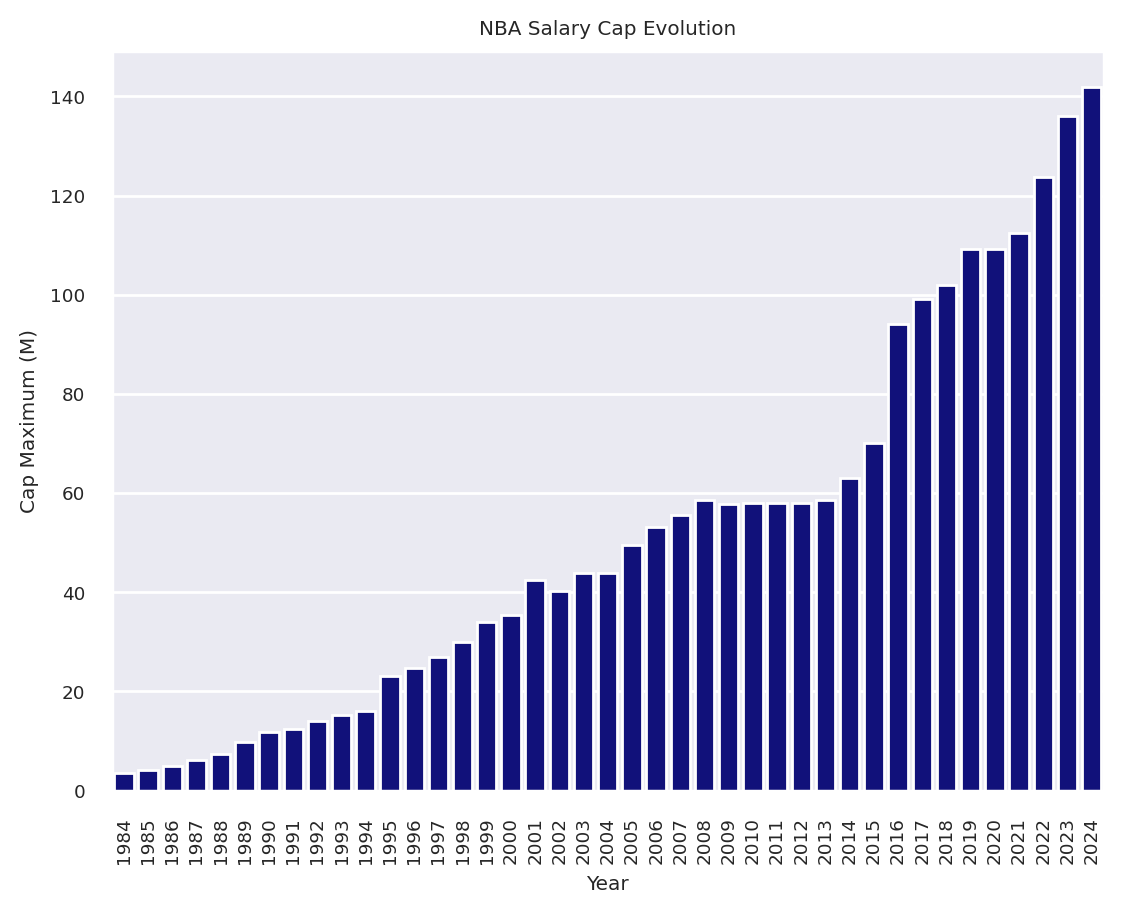

In [18]:
plt.xticks(rotation=90)
evol = sns.barplot(data=cap,x='Year',y='Cap Maximum',color='darkblue').set(title='NBA Salary Cap Evolution')
plt.ylabel('Cap Maximum (M)');
plt.savefig(path_data+sep+"salary_cap.jpg", dpi=300)

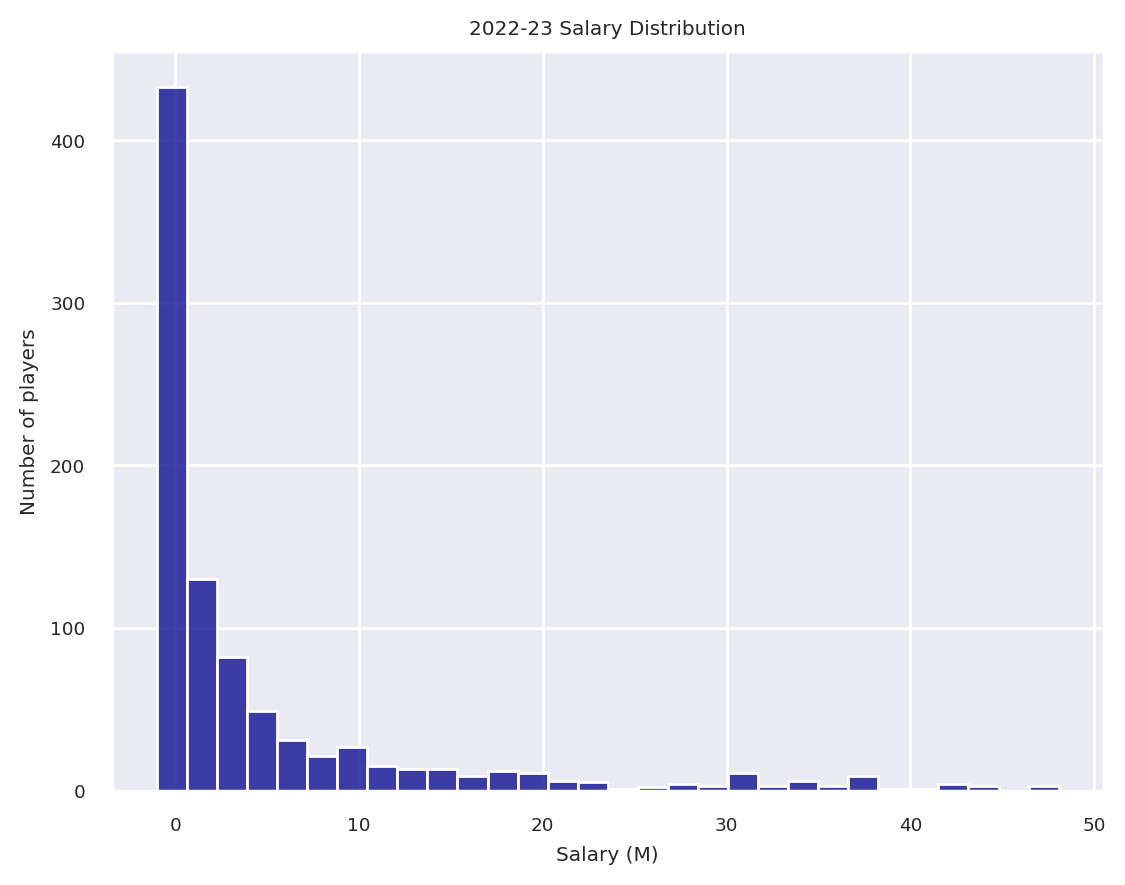

In [19]:
# Salary distribution
sns.histplot(data=salary,x='2022-23',bins=30,color='darkblue').set(title='2022-23 Salary Distribution');
plt.xlabel('Salary (M)')
plt.ylabel('Number of players')
plt.savefig(path_data+sep+"salary_dist.jpg",dpi=300)

## Modeling

In [73]:
# Function for metrics
def func_metrics(y_test, y_pred, metrics, modelo):

    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),3) # RMSE
    r2 = round(r2_score(y_test, y_pred),3) # R²

    dict_met = {'Model': [modelo],
                'RMSE': [rmse],
                'R²': [r2]}

    metric = pd.DataFrame(data=dict_met)
    metrics = pd.concat([metrics,metric])

    return metrics

In [79]:
def train_test_data(df, test_size=0.2, val_size=0.1, random_state=42):
    # Extracting data for the 2022-23 season (FAs)
    FA = df[df['Season S-1'] == '2022-23']

    # Removing data for the 2022-23 season from the main dataset
    df = df[df['Season S-1'] != '2022-23']

    # Separating features and target variable for FAs
    FA_X = FA.drop(columns={'Player', 'Tm', 'Salary S', 'Season S-1', '% of Cap S'})
    FA_y = FA['% of Cap S']

    # Separating features and target variable for the main dataset
    X = df.drop(columns={'Player', 'Tm', 'Salary S', 'Season S-1', '% of Cap S'})
    y = df['% of Cap S']

    # Splitting the main dataset into training, validation, and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(test_size + val_size), random_state=random_state)

    # Further splitting the temporary set into validation and testing sets
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(val_size / (test_size + val_size)),
                                                    random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test



In [80]:
def func_scaler(X_train, X_val, X_test):
    scaler = StandardScaler()

    # Fit the scaler on the training set
    scaler.fit(X_train)

    # Transform the training, validation, and testing sets
    scaled_X_train = scaler.transform(X_train)
    scaled_X_val = scaler.transform(X_val)
    scaled_X_test = scaler.transform(X_test)

    return scaled_X_train, scaled_X_val, scaled_X_test

In [82]:
X_train, X_val, X_test, y_train, y_val, y_test = train_test_data(res)
scaled_X_train, scaled_X_val, scaled_X_test = func_scaler(X_train, X_val, X_test)

In [83]:
def func_models(scaled_X_train, scaled_X_test, y_train, y_test, models):
    metrics = pd.DataFrame()
    best_params = []

    for modelo in models:
        # Creating instance for each model
        if modelo=='SVM':
            param_grid = {'C': [0.001,0.01,0.1,0.5,1,2,5],
                         'kernel': ['linear','rbf','poly'],
                         'gamma': ['scale','auto'],
                         'degree': [2,3,4],
                         'epsilon': [0.1,0.5,1]}
            svr_model = SVR()
            grid = GridSearchCV(svr_model, param_grid)
            grid.fit(scaled_X_train, y_train)
            model = SVR(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif modelo=='Elastic Net':
            param_grid = {'alpha':[0.01,0.1,1,5,10,50,100],
                          'l1_ratio':[0.01,0.1,0.5,0.7,0.95,1]}
            elastic_net_model = ElasticNet()
            grid = GridSearchCV(elastic_net_model, param_grid)
            grid.fit(scaled_X_train, y_train)
            grid.best_params_
            model = ElasticNet(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif modelo=='Random Forest':
            param_grid = {'n_estimators': [15,25,50,64,100,200],
                         'max_features': [2,3,5],
                         'bootstrap': [True,False],
                         'oob_score': [True]}
            rfc = RandomForestRegressor()
            grid = GridSearchCV(rfc, param_grid)
            grid.fit(scaled_X_train, y_train)
            model = RandomForestRegressor(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif modelo=='AdaBoost':
            param_grid = {'n_estimators': [5,10,25,50,100],
                         'learning_rate': [0.01,0.05,0.1,0.25,0.5]}
            ada_model = AdaBoostRegressor()
            grid = GridSearchCV(ada_model, param_grid)
            grid.fit(scaled_X_train, y_train)
            model = AdaBoostRegressor(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif modelo=='Gradient Boosting':
            param_grid = {'n_estimators': [10,25,50],
                         'learning_rate': [0.01,0.05,0.1,0.5],
                         'max_depth': [3,4,5]}
            gb_model = GradientBoostingRegressor()
            grid = GridSearchCV(gb_model, param_grid)
            grid.fit(scaled_X_train, y_train)
            model = GradientBoostingRegressor(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif modelo=='LGBM':
            param_grid = {'learning_rate':[0.01,0.1,0.2,0.3],
                          'num_leaves':[5,10,25],
                          'min_data_in_leaf':[10,25,50],
                          'max_depth':[2,3,4],
                          'feature_fraction':[0.6,0.7,0.8,0.9],
                          'min_gain_to_split':[0,0.01,0.1,0.2],
                          'verbose':[-1]}
            lgbm_model = LGBMRegressor()
            grid = GridSearchCV(lgbm_model, param_grid)
            grid.fit(scaled_X_train, y_train)
            model = LGBMRegressor(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif modelo == 'Linear Regression':
            model = LinearRegression()
            model.fit(scaled_X_train, y_train)
            y_pred = model.predict(scaled_X_test)
            best_params.append({})  # No hyperparameters for Linear Regression

        elif modelo == 'XGBoost':
            param_grid = {
              'n_estimators': [100, 200, 300],  # Hyperparameters for XGBoost
              'learning_rate': [0.01, 0.1, 0.2],
              'max_depth': [3, 4, 5],
            }
            xgb_model = XGBRegressor()
            grid = GridSearchCV(xgb_model, param_grid)
            grid.fit(scaled_X_train, y_train)
            model = grid.best_estimator_
            best_params.append(grid.best_params_)

        elif modelo == 'Decision Tree':  # New block for Decision Tree
            param_grid = {
                'max_depth': [3, 4, 5, 6],  # Hyperparameters for Decision Tree
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
            dt_model = DecisionTreeRegressor()
            grid = GridSearchCV(dt_model, param_grid)
            grid.fit(scaled_X_train, y_train)
            model = DecisionTreeRegressor(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif modelo == 'Extra Trees':
          param_grid = {
          'n_estimators': [15, 25, 50, 64, 100, 200],
          'max_features': [2, 3, 5],
          'bootstrap': [True, False],
          'oob_score': [True]
          }
          et_model = ExtraTreesRegressor()
          grid = GridSearchCV(et_model, param_grid)
          grid.fit(scaled_X_train, y_train)
          model = ExtraTreesRegressor(**grid.best_params_)
          best_params.append(grid.best_params_)

        elif modelo == 'KNN':
            # Hyperparameter tuning for K-Nearest Neighbors
            param_grid = {
                'n_neighbors': [3, 5, 7, 9],
                'weights': ['uniform', 'distance'],
                'p': [1, 2]
            }
            knn_model = KNeighborsRegressor()
            grid = GridSearchCV(knn_model, param_grid)
            grid.fit(scaled_X_train, y_train)
            model = KNeighborsRegressor(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif modelo == 'Bagging':
          param_grid = {
          'n_estimators': [10, 20, 30],  # Adjust as needed
          'max_samples': [0.5, 0.7, 0.9],
          'max_features': [0.5, 0.7, 0.9],
          'bootstrap': [True, False],
          'bootstrap_features': [True, False]
          }
          base_model = DecisionTreeRegressor()  # You can use another base estimator if needed
          bagging_model = BaggingRegressor(base_model)
          grid = GridSearchCV(bagging_model, param_grid)
          grid.fit(scaled_X_train, y_train)
          model = BaggingRegressor(base_model, **grid.best_params_)
          best_params.append(grid.best_params_)

        model.fit(scaled_X_train, y_train)

        pickle.dump(model,open(path_data+sep+'Models'+sep+modelo+'_FAs.dat','wb'))

        y_pred = model.predict(scaled_X_test)
        metrics = func_metrics(y_test, y_pred, metrics, modelo)

    np.savetxt(path_data+sep+r'Models\params_FAs.csv', best_params, delimiter =', ', fmt ='% s')

    metrics['R²'] = metrics['R²'].apply(lambda x: '%.3f' % x)

    return metrics, best_params

In [84]:
metrics, best_params = func_models(scaled_X_train, scaled_X_test, y_train, y_test, models)

In [85]:
metrics

,Model,RMSE,R²
0,SVM,1.28,0.966
0,Random Forest,2.12,0.907
0,Elastic Net,1.35,0.962
0,AdaBoost,1.80,0.933
0,Gradient Boosting,1.43,0.957
0,LGBM,1.78,0.935
0,Linear Regression,4.80,0.522
0,XGBoost,1.42,0.958
0,Decision Tree,1.15,0.973
0,Extra Trees,2.38,0.883


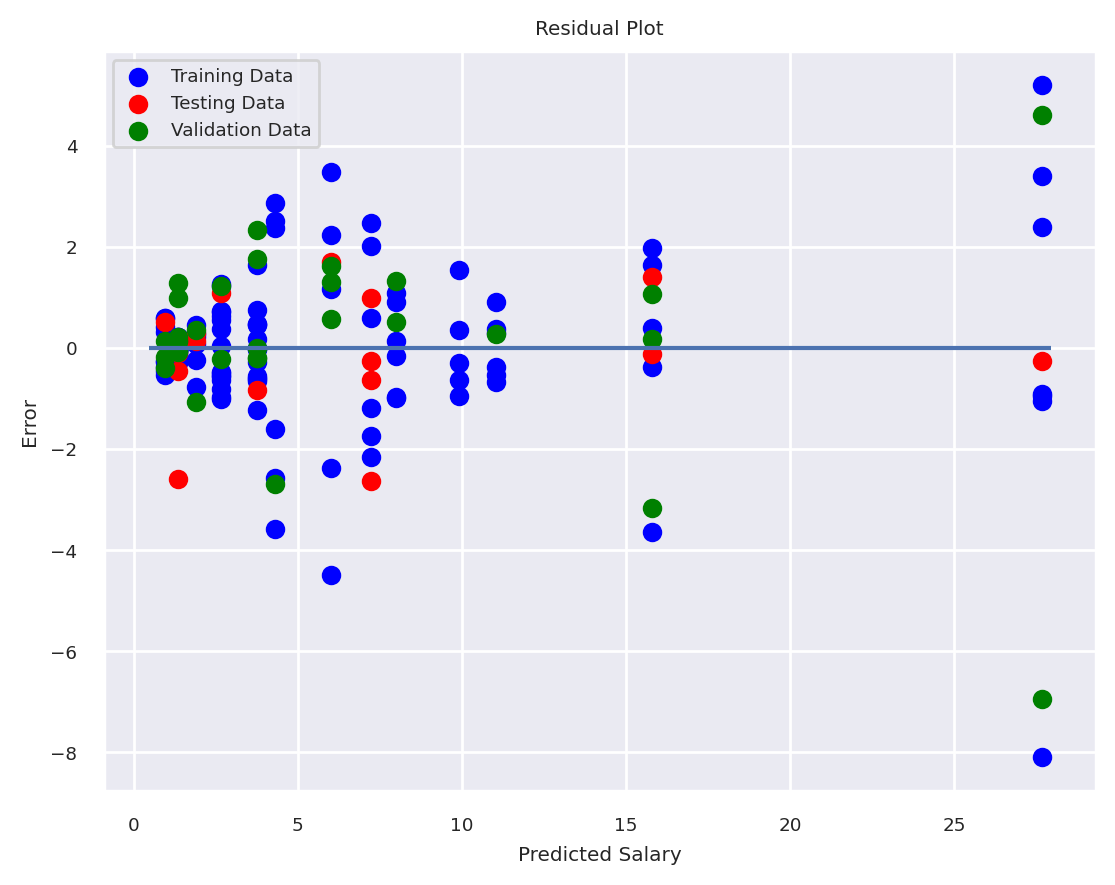

In [89]:
rf_model = pickle.load(open(path_data+sep+'Models'+sep+'Decision Tree_FAs.dat','rb'))

plt.scatter(rf_model.predict(scaled_X_train), rf_model.predict(scaled_X_train) - y_train, c="blue", label="Training Data")
plt.scatter(rf_model.predict(scaled_X_test), rf_model.predict(scaled_X_test) - y_test, c="red", label="Testing Data")
plt.scatter(rf_model.predict(scaled_X_val), rf_model.predict(scaled_X_val) - y_val, c="green", label="Validation Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.xlabel('Predicted Salary')
plt.ylabel('Error')
plt.title('Residual Plot');

## Results

In [90]:
def predict(df, modelos):

    final_results = pd.DataFrame()
    results = df[['Player','Season S-1','Salary S','Cap Maximum S','% of Cap S','C','PF','PG','SF','SG']].copy()

    def get_position(row):
        if row['C'] == 1:
            return 'C'
        elif row['PF'] == 1:
            return 'PF'
        elif row['PG'] == 1:
            return 'PG'
        elif row['SF'] == 1:
            return 'SF'
        elif row['SG'] == 1:
            return 'SG'
        else:
            return None

    results['Pos'] = results.apply(get_position, axis=1)
    results = results.drop(columns={'C','PF','PG','SF','SG'})

    X = df.drop(columns={'Player','Tm','Salary S','Season S-1','% of Cap S'})
    y = df['% of Cap S']

    scaler = pickle.load(open(path_data+sep+'Models'+sep+'standard_scaler_FAs.dat','rb'))

    scaled_X = scaler.transform(X)

    for modelo in modelos:

        # Opening the models already created
        model = pickle.load(open(path_data+sep+'Models'+sep+modelo+'_FAs.dat','rb'))

        y_pred = model.predict(scaled_X)

        results['Predicted % of Cap S '+modelo] = pd.Series(y_pred).values

        results['Predicted Salary S '+modelo] = results['Predicted % of Cap S '+modelo]/100*results['Cap Maximum S']

        results['Dif '+modelo] = results['Salary S']-results['Predicted Salary S '+modelo]

    final_results = results.sort_values(by='Salary S',ascending=False).reset_index(drop=True)

    return final_results

In [91]:
final_results = predict(res, models)
final_results

,Player,Season S-1,Salary S,Cap Maximum S,% of Cap S,Pos,Predicted % of Cap S SVM,Predicted Salary S SVM,Dif SVM,Predicted % of Cap S Random Forest,Predicted Salary S Random Forest,Dif Random Forest,Predicted % of Cap S Elastic Net,Predicted Salary S Elastic Net,Dif Elastic Net,Predicted % of Cap S AdaBoost,Predicted Salary S AdaBoost,Dif AdaBoost,Predicted % of Cap S Gradient Boosting,Predicted Salary S Gradient Boosting,Dif Gradient Boosting,Predicted % of Cap S LGBM,Predicted Salary S LGBM,Dif LGBM,Predicted % of Cap S Linear Regression,Predicted Salary S Linear Regression,Dif Linear Regression,Predicted % of Cap S XGBoost,Predicted Salary S XGBoost,Dif XGBoost,Predicted % of Cap S Decision Tree,Predicted Salary S Decision Tree,Dif Decision Tree,Predicted % of Cap S Extra Trees,Predicted Salary S Extra Trees,Dif Extra Trees,Predicted % of Cap S KNN,Predicted Salary S KNN,Dif KNN,Predicted % of Cap S Bagging,Predicted Salary S Bagging,Dif Bagging
0,Russell Westbrook,2021-22,47.08,136.02,34.61,PG,31.49,42.83,4.25,23.54,32.01,15.07,29.97,40.77,6.31,30.37,41.30,5.78,32.20,43.79,3.29,29.69,40.38,6.70,24.00,32.64,14.44,24.69,33.58,13.50,27.67,37.63,9.45,22.27,30.29,16.79,20.06,27.29,19.79,23.56,32.04,15.04
1,Russell Westbrook,2020-21,44.21,123.66,35.75,PG,34.39,42.52,1.69,28.27,34.95,9.26,33.38,41.28,2.93,35.75,44.21,0.00,34.32,42.44,1.77,33.97,42.00,2.21,31.17,38.55,5.66,29.25,36.17,8.04,27.67,34.21,10.00,27.87,34.47,9.74,31.81,39.33,4.88,26.48,32.74,11.47
2,Fred VanVleet,2022-23,40.81,142.00,28.74,PG,17.36,24.66,16.15,18.71,26.57,14.23,16.10,22.86,17.95,14.69,20.86,19.95,17.54,24.91,15.90,24.01,34.09,6.72,15.83,22.48,18.32,14.73,20.92,19.89,15.80,22.43,18.38,18.50,26.27,14.54,20.42,29.00,11.80,19.24,27.32,13.48
3,Kyrie Irving,2021-22,38.92,136.02,28.61,PG,27.37,37.23,1.69,24.68,33.57,5.35,25.10,34.14,4.78,28.60,38.90,0.01,28.54,38.82,0.09,28.35,38.56,0.36,27.01,36.74,2.18,27.00,36.72,2.19,27.67,37.63,1.29,25.67,34.92,4.00,26.80,36.46,2.46,25.09,34.13,4.79
4,Khris Middleton,2021-22,37.98,136.02,27.93,SF,26.46,36.00,1.99,22.59,30.72,7.26,25.43,34.59,3.39,27.98,38.05,-0.07,28.63,38.95,-0.97,27.46,37.35,0.63,24.04,32.70,5.29,24.47,33.28,4.71,27.67,37.63,0.35,23.05,31.35,6.64,21.75,29.59,8.40,23.45,31.89,6.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,Jack White,2022-23,0.60,142.00,0.42,SF,-0.19,-0.27,0.87,1.38,1.96,-1.36,-0.07,-0.10,0.70,2.45,3.47,-2.87,2.12,3.01,-2.41,1.07,1.52,-0.92,-1.57,-2.23,2.83,1.63,2.31,-1.71,1.36,1.93,-1.33,1.39,1.97,-1.37,1.28,1.82,-1.22,1.09,1.54,-0.94
242,Jeff Dowtin,2021-22,0.51,136.02,0.37,PG,-0.48,-0.65,1.16,1.32,1.80,-1.29,0.25,0.35,0.16,2.44,3.32,-2.81,2.77,3.76,-3.26,1.34,1.82,-1.32,-2.41,-3.28,3.79,1.63,2.22,-1.71,1.36,1.85,-1.34,1.38,1.87,-1.36,1.42,1.93,-1.42,1.33,1.81,-1.30
243,Luka Garza,2021-22,0.51,136.02,0.37,C,0.09,0.12,0.39,1.01,1.37,-0.86,0.24,0.33,0.18,2.38,3.24,-2.73,0.40,0.55,-0.04,0.11,0.15,0.36,1.32,1.80,-1.29,1.55,2.11,-1.60,0.97,1.31,-0.80,1.10,1.50,-0.99,0.76,1.04,-0.53,0.84,1.15,-0.64
244,Nathan Knight,2020-21,0.46,123.66,0.37,PF,1.28,1.59,-1.13,0.81,1.00,-0.54,1.09,1.35,-0.88,2.38,2.94,-2.48,0.58,0.72,-0.25,0.40,0.50,-0.04,3.76,4.66,-4.19,1.55,1.92,-1.46,1.36,1.68,-1.22,1.04,1.29,-0.82,0.68,0.84,-0.38,1.02,1.27,-0.80


In [92]:
final_results.sort_values(by='Dif Decision Tree').reset_index(drop=True)

,Player,Season S-1,Salary S,Cap Maximum S,% of Cap S,Pos,Predicted % of Cap S SVM,Predicted Salary S SVM,Dif SVM,Predicted % of Cap S Random Forest,Predicted Salary S Random Forest,Dif Random Forest,Predicted % of Cap S Elastic Net,Predicted Salary S Elastic Net,Dif Elastic Net,Predicted % of Cap S AdaBoost,Predicted Salary S AdaBoost,Dif AdaBoost,Predicted % of Cap S Gradient Boosting,Predicted Salary S Gradient Boosting,Dif Gradient Boosting,Predicted % of Cap S LGBM,Predicted Salary S LGBM,Dif LGBM,Predicted % of Cap S Linear Regression,Predicted Salary S Linear Regression,Dif Linear Regression,Predicted % of Cap S XGBoost,Predicted Salary S XGBoost,Dif XGBoost,Predicted % of Cap S Decision Tree,Predicted Salary S Decision Tree,Dif Decision Tree,Predicted % of Cap S Extra Trees,Predicted Salary S Extra Trees,Dif Extra Trees,Predicted % of Cap S KNN,Predicted Salary S KNN,Dif KNN,Predicted % of Cap S Bagging,Predicted Salary S Bagging,Dif Bagging
0,Russell Westbrook,2022-23,3.84,142.00,2.70,PG,32.30,45.87,-42.03,20.23,28.72,-24.89,29.17,41.42,-37.58,28.59,40.60,-36.76,26.38,37.46,-33.63,26.54,37.69,-33.85,20.15,28.61,-24.78,24.69,35.06,-31.22,27.67,39.29,-35.45,20.42,29.00,-25.16,15.02,21.32,-17.49,23.17,32.90,-29.07
1,Eric Gordon,2022-23,3.20,142.00,2.25,SG,12.83,18.22,-15.02,9.79,13.90,-10.70,12.12,17.21,-14.01,11.19,15.89,-12.69,14.18,20.14,-16.94,17.06,24.23,-21.03,6.24,8.86,-5.67,12.67,17.98,-14.79,15.80,22.43,-19.23,10.17,14.43,-11.24,7.34,10.42,-7.22,12.77,18.13,-14.94
2,Kevin Love,2022-23,3.84,142.00,2.70,PF,20.71,29.40,-25.57,11.15,15.83,-12.00,18.41,26.14,-22.31,22.92,32.54,-28.71,18.58,26.38,-22.54,17.38,24.68,-20.85,16.48,23.41,-19.57,21.46,30.48,-26.64,15.80,22.43,-18.60,11.85,16.82,-12.99,11.34,16.11,-12.27,19.80,28.11,-24.28
3,Malik Beasley,2022-23,2.02,142.00,1.42,SG,10.39,14.75,-12.73,9.11,12.93,-10.91,10.35,14.70,-12.68,9.30,13.20,-11.18,7.63,10.83,-8.81,10.15,14.41,-12.39,5.62,7.98,-5.96,8.70,12.35,-10.33,11.05,15.70,-13.68,9.73,13.81,-11.79,6.86,9.74,-7.72,9.70,13.78,-11.76
4,Jae Crowder,2022-23,2.02,142.00,1.42,PF,6.86,9.74,-7.72,4.27,6.06,-4.04,5.81,8.25,-6.23,5.19,7.37,-5.35,1.69,2.40,-0.38,7.27,10.32,-8.30,5.12,7.26,-5.24,4.65,6.60,-4.58,9.92,14.08,-12.06,5.07,7.20,-5.18,4.56,6.47,-4.45,5.04,7.16,-5.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,Kyle Kuzma,2022-23,25.57,142.00,18.01,PF,9.62,13.65,11.91,15.29,21.71,3.86,10.29,14.61,10.95,9.20,13.06,12.50,9.48,13.46,12.11,10.98,15.60,9.97,1.81,2.58,22.99,8.44,11.98,13.59,9.92,14.08,11.49,13.26,18.84,6.73,9.91,14.07,11.50,9.75,13.84,11.73
242,Dillon Brooks,2022-23,22.63,142.00,15.93,SF,7.68,10.91,11.72,8.09,11.49,11.14,7.87,11.17,11.46,9.30,13.20,9.43,8.84,12.55,10.07,8.18,11.62,11.01,4.24,6.01,16.61,8.51,12.09,10.54,7.23,10.27,12.36,9.65,13.70,8.93,8.78,12.47,10.16,8.49,12.06,10.57
243,Max Strus,2022-23,14.49,142.00,10.20,SF,1.48,2.10,12.39,5.60,7.96,6.53,2.47,3.50,10.99,3.44,4.88,9.61,3.12,4.43,10.06,3.29,4.67,9.82,-0.99,-1.41,15.90,3.77,5.35,9.13,1.36,1.93,12.55,7.02,9.97,4.51,3.95,5.61,8.87,4.33,6.15,8.34
244,Fred VanVleet,2022-23,40.81,142.00,28.74,PG,17.36,24.66,16.15,18.71,26.57,14.23,16.10,22.86,17.95,14.69,20.86,19.95,17.54,24.91,15.90,24.01,34.09,6.72,15.83,22.48,18.32,14.73,20.92,19.89,15.80,22.43,18.38,18.50,26.27,14.54,20.42,29.00,11.80,19.24,27.32,13.48


## Free Agents - 2023-24 Season

In [93]:
free_agents = final_results[['Player','Salary S','% of Cap S','Predicted Salary S Decision Tree',
                            'Predicted % of Cap S Decision Tree','Dif Decision Tree']][final_results['Season S-1']=='2022-23'].sort_values('Dif Decision Tree')
free_agents

,Player,Salary S,% of Cap S,Predicted Salary S Decision Tree,Predicted % of Cap S Decision Tree,Dif Decision Tree
130,Russell Westbrook,3.84,2.70,39.29,27.67,-35.45
135,Eric Gordon,3.20,2.25,22.43,15.80,-19.23
129,Kevin Love,3.84,2.70,22.43,15.80,-18.60
182,Malik Beasley,2.02,1.42,15.70,11.05,-13.68
174,Jae Crowder,2.02,1.42,14.08,9.92,-12.06
...,...,...,...,...,...,...
16,Kyle Kuzma,25.57,18.01,14.08,9.92,11.49
19,Dillon Brooks,22.63,15.93,10.27,7.23,12.36
36,Max Strus,14.49,10.20,1.93,1.36,12.55
2,Fred VanVleet,40.81,28.74,22.43,15.80,18.38


In [94]:
a = int(len(free_agents) / 2)+5
b = int((len(free_agents) / 2) + 10)
free_agents.iloc[a:b]

,Player,Salary S,% of Cap S,Predicted Salary S Decision Tree,Predicted % of Cap S Decision Tree,Dif Decision Tree
155,Keita Bates-Diop,2.35,1.65,1.93,1.36,0.41
157,Yuta Watanabe,2.35,1.65,1.93,1.36,0.41
148,Thomas Bryant,2.53,1.78,1.93,1.36,0.59
189,Duane Washington Jr,2.02,1.42,1.37,0.97,0.65
179,Sandro Mamukelashvili,2.02,1.42,1.37,0.97,0.65


In [95]:
metr = pd.DataFrame()
metr = func_metrics(free_agents['% of Cap S'], free_agents['Predicted % of Cap S Decision Tree'], metr, 'Decision Tree')
metr

,Model,RMSE,R²
0,Decision Tree,5.48,0.17


## Position Analysis - 2023-24 Season

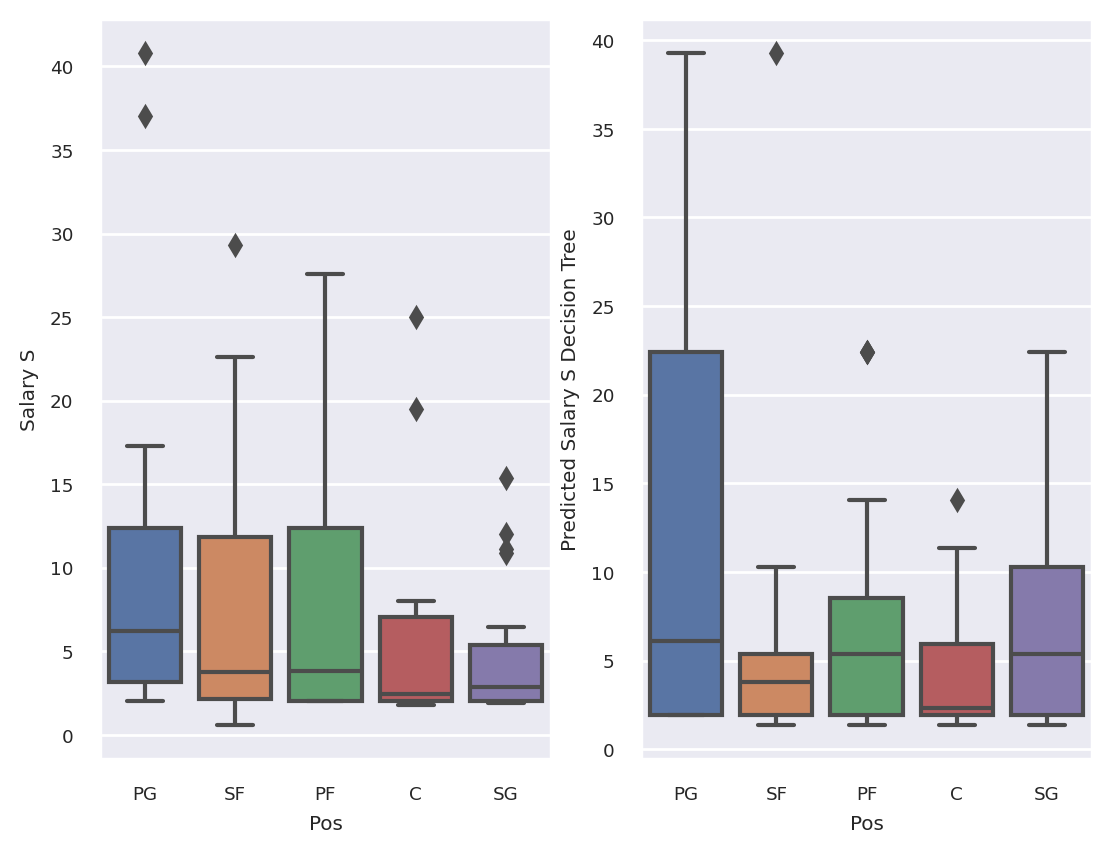

In [96]:
fig, ax = plt.subplots(1,2)

positions = final_results[final_results['Season S-1']=='2022-23']

sns.boxplot(x='Pos', y='Salary S', data=positions, ax=ax[0])
sns.boxplot(x='Pos', y='Predicted Salary S Decision Tree', data=positions, ax=ax[1]);

In [97]:
positions.groupby('Pos').agg({'Salary S':'mean',
                            'Predicted Salary S Decision Tree':'mean',
                             'Player':'count'}).sort_values(by='Salary S', ascending=False).reset_index()

,Pos,Salary S,Predicted Salary S Decision Tree,Player
0,PG,11.71,12.57,13
1,PF,8.82,7.48,21
2,SF,8.72,6.86,12
3,C,5.61,4.79,18
4,SG,4.87,6.85,20
